Full Name: Juan Pablo Grimaldi

Username: jgri0027

ID: 32980523



### 1.1.1 Create SparkSession<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write the code to get a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to enable the maximum partition size not exceed 10MB, and to run locally with as many working processors as local cores on your machine

In [41]:
#
# Import SparkConf class into program
from pyspark import SparkConf
from pyspark.sql import SparkSession  # Spark SQL

# the below setup will run Spark in local mode with * working processors (equal to logical cores on the machine)
master = "local[*]"

# Setup `appName` field to be displayed at Spark cluster UI page
app_name = "FIT5202 Assignment 2"
# Setup configuration parameters for Spark
spark_conf = (SparkConf()
              .setMaster(master)
              .setAppName(app_name)
              .set('spark.sql.files.maxPartitionBytes', '10mb'))

# Setup SparkSession and configure it with Melbourne timezone.

spark = (
    SparkSession.builder.config(conf=spark_conf)
    .config("spark.sql.session.timeZone", "UTC+11")
    .config("spark.driver.extraJavaOptions", "-Duser.timezone=GMT+11")
    .config("spark.executor.extraJavaOptions", "-Duser.timezone=GMT+11")
    .getOrCreate()
)
sc = spark.sparkContext
sc.setLogLevel("ERROR")

## User Defined Functions

In [42]:
def schema_display(df, name):
    """
    print schema of a Spark Dataframe
    df: Spark Dataframe object
    name: Given name to the object
    """
    print("---- {} ----".format(name))
    pp.pprint(df.printSchema())


def check_nulls_v2(df, name):
    """
    Check for missing data and null values in Spark Dataframe

    """
    print(f"---- {name} Missing/Null values ----")
    df.select([
        (
            count(when((isnan(c) | col(c).isNull()), c)) if t not in ("timestamp", "date", "boolean")
            else count(when(col(c).isNull(), c))
        ).alias(c)
        for c, t in df.dtypes if c in df.columns
    ]).show()
    print(f"total count for {name}:", df.count())


def basic_statistics(df, name):
    """
    Basic statistics for numeric and non-numeric columns in a given dataframe.
    The function splits columns into numeric and non-numeric
    """
    new_df = ps.DataFrame(df)
    num_cols = []
    nonnum_cols = []
    # split columns into numeric and non-numeric
    for each in df.dtypes:
        if each[1] in ('string', 'boolean') and each[0] not in ('Store', 'Dept', 'Date'):
            nonnum_cols.append(each[0])
        else:
            num_cols.append(each[0])
    # numeric column summary
    print(f"---- {name} Dataframe Numeric Statistical Summary ----\n")
    pp.pprint(new_df.describe())
    print("\n")
    # non-numeric column summary
    print(f"---- {name} Dataframe Non-Numeric Statistical Summary ----\n")
    for each in nonnum_cols:
        print(f"---- {each} Summary ----\n")
        pp.pprint(new_df[each].value_counts().sort_values(ascending=False)[:6])

### 1.1.2 Define schemas<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write code to define the data schema for features, sales and stores datasets, following the data types suggested in the metadata file.

In [43]:
# setup
import pprint as pp
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import seaborn as sns


import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    col, lit, to_date, to_timestamp, isnan, when, count
)
from pyspark.sql.types import (
    BooleanType,
    FloatType,
    IntegerType,
    StringType,
    StructField,
    StructType,
    DateType,
    DoubleType
)

import warnings
warnings.filterwarnings('ignore')

In [44]:
# assign data type for each dataframe column
# features data type
features_labels = [
    ("Store", StringType()),
    ("Date", DateType()),
    ("Temperature", FloatType()),
    ("Fuel_Price", FloatType()),
    ("MarkDown1", FloatType()),
    ("MarkDown2", FloatType()),
    ("MarkDown3", FloatType()),
    ("MarkDown4", FloatType()),
    ("MarkDown5", FloatType()),
    ("CPI", FloatType()),
    ("Unemployment", FloatType()),
    ("IsHoliday", BooleanType()),
]
# sales data types
sales_labels = [
    ("Store", StringType()),
    ("Dept", StringType()),
    ("Date", DateType()),
    ("Weekly_Sales", FloatType()),
    ("IsHoliday", BooleanType()),
]
# stores data type
stores_labels = [
    ("Store", StringType()),
    ("Type", StringType()),
    ("Size", IntegerType()),
]

# features schema
features_schema = StructType(
    [StructField(x[0], x[1], False) for x in features_labels])
# sales schema
sales_schema = StructType([StructField(x[0], x[1], True)
                          for x in sales_labels])
# stores schema
stores_schema = StructType([StructField(x[0], x[1], True)
                           for x in stores_labels])

### 1.1.3 Load three DF<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Using predefined schema, write code to load the features, sales and stores csv files into separate dataframes. Print the schemas for all of the dataframes

In [45]:
# read with utf-8 encoding.

df_features = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .option("dateFormat", "d/M/y")
    .load("data/Features.csv", schema=features_schema)
)

df_sales = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .option("dateFormat", "d/M/y")
    .load("data/sales.csv", schema=sales_schema)
)

df_stores = (
    spark.read.format("csv")
    .option("header", True)
    .option("encoding", "UTF-8")
    .option("dateFormat", "d/M/y")
    .load("data/stores.csv", schema=stores_schema)
)

In [46]:
# print schema
schema_display(df_features, "Features DF Schema")
schema_display(df_sales, "Sales DF Schema")
schema_display(df_stores, "Stores DF Schema")

---- Features DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Temperature: float (nullable = true)
 |-- Fuel_Price: float (nullable = true)
 |-- MarkDown1: float (nullable = true)
 |-- MarkDown2: float (nullable = true)
 |-- MarkDown3: float (nullable = true)
 |-- MarkDown4: float (nullable = true)
 |-- MarkDown5: float (nullable = true)
 |-- CPI: float (nullable = true)
 |-- Unemployment: float (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

None
---- Sales DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Dept: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Weekly_Sales: float (nullable = true)
 |-- IsHoliday: boolean (nullable = true)

None
---- Stores DF Schema ----
root
 |-- Store: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Size: integer (nullable = true)

None


<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE"> Documentation: </strong>
Explain the spark object you used to load the data into one of a dataframe (e.g., 1. spark objects do you use. 2. parameters) (1 mark)
</div>

### 1.2.1 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write code to show the total ‘null’ counts for each column in all of the three dataframes.

In [47]:
check_nulls_v2(df_features, "Features")
check_nulls_v2(df_sales, "Sales")
check_nulls_v2(df_stores, "Stores")

---- Features Missing/Null values ----
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|Store|Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|IsHoliday|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|    0|   0|          0|         0|     4158|     5269|     4577|     4726|     4140|585|         585|        0|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+

total count for Features: 8190
---- Sales Missing/Null values ----
+-----+----+----+------------+---------+
|Store|Dept|Date|Weekly_Sales|IsHoliday|
+-----+----+----+------------+---------+
|    0|   0|   0|           0|        0|
+-----+----+----+------------+---------+

total count for Sales: 421570
---- Stores Missing/Null values ----
+-----+----+----+
|Store|Type|Size|
+-----+----+----+
|

In [48]:
# remove nulls for CPI and unemployment
# Markdown nulls are far too many to remove.
df_features = df_features.na.drop(subset=['CPI', 'Unemployment'])

In [49]:
check_nulls_v2(df_features, "Features")

---- Features Missing/Null values ----
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|Store|Date|Temperature|Fuel_Price|MarkDown1|MarkDown2|MarkDown3|MarkDown4|MarkDown5|CPI|Unemployment|IsHoliday|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+
|    0|   0|          0|         0|     4156|     5164|     4521|     4631|     4140|  0|           0|        0|
+-----+----+-----------+----------+---------+---------+---------+---------+---------+---+------------+---------+

total count for Features: 7605


In [50]:
# comment the amount of records deleted

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#006DAE"> Documentation: </strong>
Explain the process in this task (e.g., the steps in a function you have created). Any method of a pyspark object used, the parameters, and the variables involved (1 mark)
</div>

### 1.2.2 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

For each features, sales and stores dataframe, write code to show the basic statistics (including count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile) for each numeric column. For each non-numeric feature in each dataframe, display the top-5 values and the corresponding counts, except for the columns of “Store”, “Dept" and "Date

In [51]:
basic_statistics(df_features, "Features")

---- Features Dataframe Numeric Statistical Summary ----

       Temperature   Fuel_Price      MarkDown1      MarkDown2      MarkDown3     MarkDown4      MarkDown5          CPI  Unemployment
count  7605.000000  7605.000000    3449.000000    2441.000000    3084.000000   2974.000000    3465.000000  7605.000000   7605.000000
mean     58.297325     3.389624    7346.686886    3918.187852    2026.774061   3349.993416    4257.267304   172.460809      7.826821
std      18.709862     0.441461    9724.747757    9522.212767   12185.103573   7180.600016   14050.354070    39.738346      1.877259
min      -7.290000     2.472000   -2781.450000    -265.760000    -179.260000      0.220000    -185.170000   126.064000      3.684000
25%      44.700000     3.001000    1673.310000      57.960000       5.720000    282.720000    1472.860000   132.364840      6.634000
50%      59.250000     3.494000    4879.580000     345.500000      30.290000   1107.790000    2772.050000   182.716840      7.806000
75%      72

In [52]:
basic_statistics(df_sales, "Sales")

---- Sales Dataframe Numeric Statistical Summary ----

        Weekly_Sales
count  421570.000000
mean    15981.258121
std     22711.183512
min     -4988.940000
25%      2079.390000
50%      7612.100000
75%     20200.750000
max    693099.400000


---- Sales Dataframe Non-Numeric Statistical Summary ----

---- IsHoliday Summary ----

False    391909
True      29661
Name: IsHoliday, dtype: int64


In [53]:
basic_statistics(df_stores, "Sales")

---- Sales Dataframe Numeric Statistical Summary ----

                Size
count      45.000000
mean   130287.600000
std     63825.271991
min     34875.000000
25%     70713.000000
50%    126512.000000
75%    202307.000000
max    219622.000000


---- Sales Dataframe Non-Numeric Statistical Summary ----

---- Type Summary ----

A    22
B    17
C     6
Name: Type, dtype: int64


### 1.2.3 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Write code to display a histogram to show the distribution of the weekly sales for stores with log-scale for the frequency axis. Describe what you observe from the plot

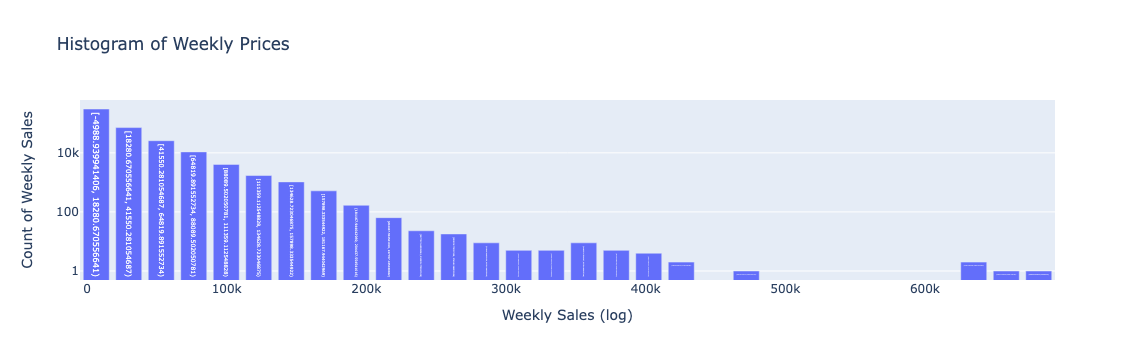

CPU times: user 56.5 ms, sys: 12 ms, total: 68.4 ms
Wall time: 469 ms


In [54]:
%%time
# create a Pyspark Pandas API object and access plot method
fig = (ps.DataFrame(df_sales.select('Weekly_Sales'))
       .plot.hist(bins=30, title='Histogram of Weekly Prices'))
# update x and y labels
fig.update_layout(
    yaxis_title="Count of Weekly Sales", xaxis_title="Weekly Sales (log)")
# transform the frequency axis to log.
fig.update_yaxes(type='log')
fig.show()

### 1.2.3 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Apart from that, Draw a line-plot to show the trend of the average weekly sales of the month based on the different stores

In [55]:
# average weekly sales by store
# group it for performance improvement and
sales_monthly = (df_sales
                 .withColumn("Month", F.month(col("Date")))
                 .groupby("Store", "Month")
                 .agg(F.sum("Weekly_Sales").cast('Decimal(12,2)').alias("Weekly_Sales"))
                 )

# pass the spark DF object to a PySpark Pandas API object
sales_monthly_pd = sales_monthly.toPandas()

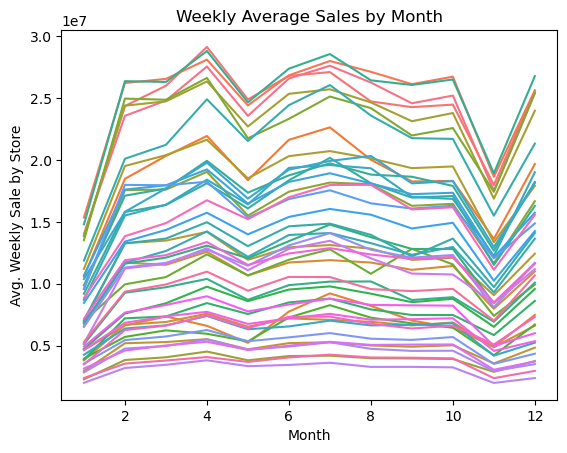

In [56]:
# create a seaborn line plot
lineplot = sns.lineplot(data=sales_monthly_pd, x='Month',
                        y='Weekly_Sales', hue='Store')

# matplotlibe settings
plt.legend([], [], frameon=False)
plt.title("Weekly Average Sales by Month")
plt.ylabel("Avg. Weekly Sale by Store")
plt.show();

It can be seen that stores remain in bands of weekly sales, but they all show a similar pattern by month.

In [57]:
# it can be seen there's a clear drop in sales in November as well as January.

### 1.2.4 Exploring the data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

Explore the data provided and write code to present two plots totally worthy of presenting to the MelbourneGig company, describe your plots and discuss the findings from the plots 

#### Use Case 1: Classification of Sales per Unit

In [58]:
# First we will need to aggregate the important features by date and store

In [59]:
# Group features data by date and store
features_weekly = (df_features
                   # groupby date and store
                   .groupby("Date", "Store", "IsHoliday")
                   # calculate mean and sum for numerical variables
                   .agg(F.mean("Temperature").cast('Decimal(12,2)').alias("avg_temperature"),
                        F.mean("Fuel_Price").cast(
                            'Decimal(12,2)').alias("avg_fuelprice"),
                        F.mean("CPI").cast('Decimal(12,2)').alias("avg_CPI"),
                        F.mean("Unemployment").cast(
                            'Decimal(12,2)').alias("avg_unemployment"))
                   .join(df_stores, df_features.Store == df_stores.Store, how="left")
                   .drop(df_stores.Store)
                   .drop("Type", "Size")
                   )

In [60]:
features_weekly.show(3)

+----------+-----+---------+---------------+-------------+-------+----------------+
|      Date|Store|IsHoliday|avg_temperature|avg_fuelprice|avg_CPI|avg_unemployment|
+----------+-----+---------+---------------+-------------+-------+----------------+
|2011-12-16|    1|    false|          51.63|         3.16| 219.18|            7.87|
|2013-03-08|    4|    false|          53.21|         3.65| 132.42|            3.92|
|2011-02-18|    6|    false|          59.61|         3.05| 214.78|            6.86|
+----------+-----+---------+---------------+-------------+-------+----------------+
only showing top 3 rows



In [61]:
# adding the store sales by month
# calculating both sales per unit and creating categorical variable on
# threshold
df_sales_store = (df_sales
                  # join sales to dataframe
                  .join(df_stores, df_sales.Store == df_stores.Store, how="left")
                  # drop one of the store columns
                  .drop(df_stores.Store)
                  # group data by Store, Date and Size
                  .groupby("Store", "Type", "Date", "Size")
                  # calculate the Weekly Sales as sum of sales by store
                  .agg(F.round(F.sum("Weekly_Sales"), 2).alias("Weekly_Sales"))
                  )

# combine features with sales_store df
df_features_store = (features_weekly.join(
    df_sales_store, ['Date', 'Store'], how='right'))

In [62]:
df_features_store.show(10)

+----------+-----+---------+---------------+-------------+-------+----------------+----+------+------------+
|      Date|Store|IsHoliday|avg_temperature|avg_fuelprice|avg_CPI|avg_unemployment|Type|  Size|Weekly_Sales|
+----------+-----+---------+---------------+-------------+-------+----------------+----+------+------------+
|2010-12-10|    1|    false|          46.33|         2.84| 211.47|            7.84|   A|151315|  1682614.26|
|2011-09-30|    2|    false|          78.14|         3.36| 216.36|            7.85|   A|202307|  1650394.44|
|2011-04-01|    3|    false|          68.76|         3.52| 218.21|            7.57|   B| 37392|   374556.07|
|2012-10-12|    3|    false|          70.31|         3.60| 226.92|            6.03|   B| 37392|   410804.39|
|2011-10-21|    6|    false|          68.53|         3.35| 219.07|            6.55|   A|202505|  1417922.38|
|2010-12-17|    8|    false|          45.03|         2.87| 214.75|            6.43|   A|155078|  1220579.55|
|2011-07-29|    8| 

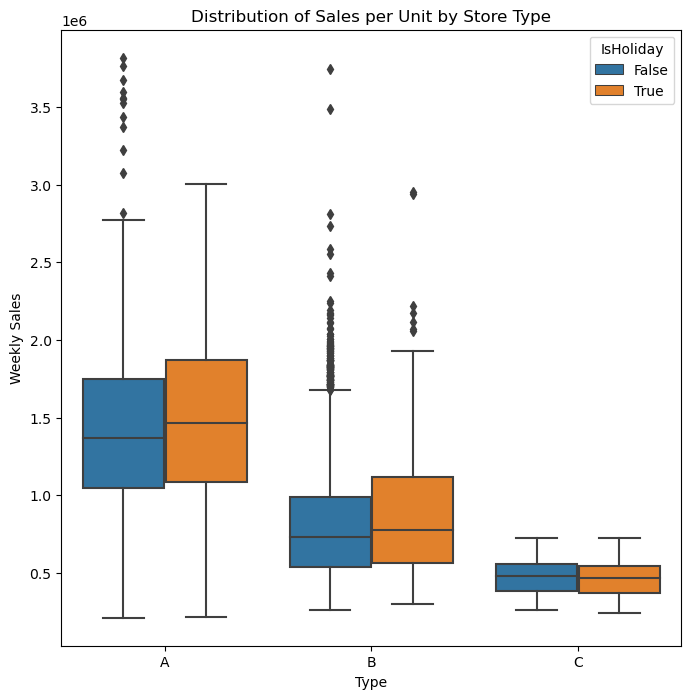

In [63]:
# matplotlib setup
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.title("Distribution of Sales per Unit by Store Type")
sns.boxplot(x="Type", y="Weekly_Sales", hue="IsHoliday",
              data=df_features_store.toPandas())
plt.ylabel("Weekly Sales")
plt.show();

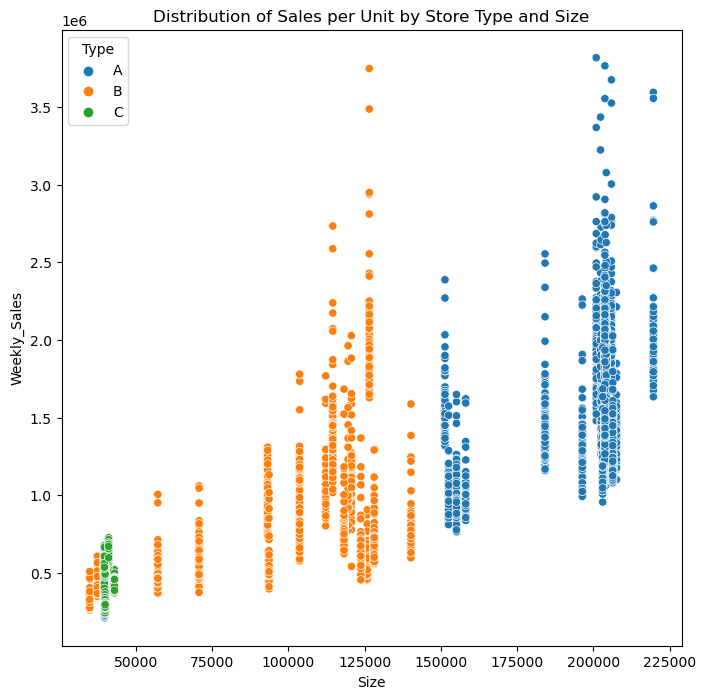

In [64]:
# matplotlib setup
fig, ax = plt.subplots(1, figsize=(8, 8))

plt.title("Distribution of Sales per Unit by Store Type and Size")

sns.scatterplot(x="Size", y="Weekly_Sales", hue="Type",
                data=df_features_store.toPandas())

plt.show();

#### Use Case 2: Weekly Sales Prediction

In [65]:
df_features_store.show(5)

+----------+-----+---------+---------------+-------------+-------+----------------+----+------+------------+
|      Date|Store|IsHoliday|avg_temperature|avg_fuelprice|avg_CPI|avg_unemployment|Type|  Size|Weekly_Sales|
+----------+-----+---------+---------------+-------------+-------+----------------+----+------+------------+
|2010-12-10|    1|    false|          46.33|         2.84| 211.47|            7.84|   A|151315|  1682614.26|
|2011-09-30|    2|    false|          78.14|         3.36| 216.36|            7.85|   A|202307|  1650394.44|
|2011-04-01|    3|    false|          68.76|         3.52| 218.21|            7.57|   B| 37392|   374556.07|
|2012-10-12|    3|    false|          70.31|         3.60| 226.92|            6.03|   B| 37392|   410804.39|
|2011-10-21|    6|    false|          68.53|         3.35| 219.07|            6.55|   A|202505|  1417922.38|
+----------+-----+---------+---------------+-------------+-------+----------------+----+------+------------+
only showing top 5 

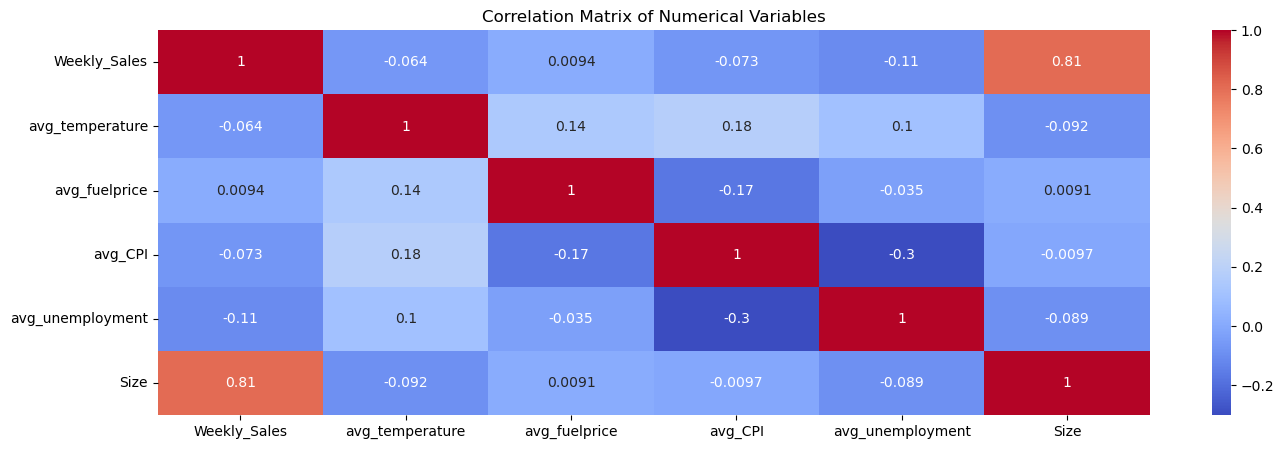

In [66]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns

# The first one would likely by a correlation plot
# select numeric columns
numeric_columns = ['Weekly_Sales', 'avg_temperature',
                   'avg_fuelprice', 'avg_CPI', 'avg_unemployment', 'Size']

corr_df = df_features_store.select(numeric_columns)

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
vector_df = assembler.transform(corr_df).select(vector_col)

matrix = Correlation.corr(vector_df, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

plt.figure(figsize=(16, 5))
sns.heatmap(cor_np,  cmap="coolwarm", annot=True,
            xticklabels=corr_df.columns,
            yticklabels=corr_df.columns)

plt.title("Correlation Matrix of Numerical Variables");

### 2.1.1 Discuss the feature selection and prepare the feature columns<a class="anchor" id="1.1.1"></a>
[Back to top](#table)

As we need to perform a one-step time-series prediction, meaning that the model’s prediction for the next weekly sales would be based on the previous weekly sales. The model will be used for future prediction Based on the data exploration from 1.2 and consider the situation we have, discuss which importances of those features (For example,which feature maybe useless and should be removed, which feature have a great impact to the label column,which features should be transformed) which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them

Answer : Put in Documentation Part - Not here

#### Copy in Documentation

The variables that seem to have more explanatory power on sales per unit are Store `Type` as well as the indicator variable `IsHoliday`. However, its clear that since stores of type C are less than half of the size of stores of type B and less than a quarter the size of C, they would have higher sales per unit all else equal. In other words, stores A and B may have more space to distribute shelves and items but that is no guarantee that they are more popular.The holiday week boolean variable also seems to have some potential explanatory power, albeit not as clear as store type. This may be due to more shoppers visiting stores near holidays to buy presents.

**Final variables**:

* Type
* IsHoliday

The second case will use a combination of numerical and categorical variables to estimate weekly sales. However, the exploratory data analysis was performed on numerical variables available on the features dataframe as well as lagged versions of weekly sales.

**Final variables**:

* avg_fuelprice
* holiday_count
* sales_chg_lag8


In [67]:
# Add this to appendix
(df_stores
 .groupby("Type")
 .agg(F.mean("Size").cast('Decimal(8,2)').alias("Avg store size"))
 .orderBy("Avg store size").show())

+----+--------------+
|Type|Avg store size|
+----+--------------+
|   C|      40541.67|
|   B|     101190.71|
|   A|     177247.73|
+----+--------------+



### 2.1.2 Discuss the feature selection and prepare the feature columns<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to create the columns based on your discussion above

Use case 1: We need a model to predict stores which achieve the goals, which means the weekly sales of the store divide the Store size is greater than 8.5, create a column called "achieve_goal" and use 1 to label those achieved data, 0 for others’ data

In [68]:
# create variable achieve goal
# create sales per unit
df_features_store = (df_features_store
                     .withColumn("Sales_Per_Unit", (col('Weekly_Sales')/col('Size')).cast('Decimal(12,2)').alias("Sales_Per_Unit"))
                     .withColumn("achieve_goal",
                                 when(col("Sales_Per_Unit") < 8.5, 0).otherwise(1))
                     )

In [69]:
df_features_store.select("achieve_goal").describe().show()

+-------+-------------------+
|summary|       achieve_goal|
+-------+-------------------+
|  count|               6435|
|   mean|0.44413364413364415|
| stddev| 0.4969077593198862|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



Use case 2: Join the DataFrames for our one-step time-series weekly sales prediction for stores. You should make sure the weekly sales of the previous week and Store Type as the feature of our model. For other columns, you can choose based on your answer in 2.1.1

In [70]:
# previous week and store type will be
# recreate the lagged variables

windowSpec = Window.partitionBy(F.col("Store")).orderBy(["Store", "Date"])

# add lagged variable
df_features_store = (df_features_store
                     .withColumn("Weekly_Sales_lag1", F.lag("Weekly_Sales", 1).over(windowSpec))
                     .withColumn("Sales_chg_lag1", (col("Weekly_Sales_lag1")/col("Weekly_Sales") - 1).cast('Decimal(12,4)'))
                     )

In [71]:
# drop na values
df_features_store = df_features_store.na.drop(subset=['Weekly_Sales_lag1'])

In [72]:
check_nulls_v2(df_features_store, "Features with Lags")

---- Features with Lags Missing/Null values ----
+----+-----+---------+---------------+-------------+-------+----------------+----+----+------------+--------------+------------+-----------------+--------------+
|Date|Store|IsHoliday|avg_temperature|avg_fuelprice|avg_CPI|avg_unemployment|Type|Size|Weekly_Sales|Sales_Per_Unit|achieve_goal|Weekly_Sales_lag1|Sales_chg_lag1|
+----+-----+---------+---------------+-------------+-------+----------------+----+----+------------+--------------+------------+-----------------+--------------+
|   0|    0|        0|              0|            0|      0|               0|   0|   0|           0|             0|           0|                0|             0|
+----+-----+---------+---------------+-------------+-------+----------------+----+----+------------+--------------+------------+-----------------+--------------+

total count for Features with Lags: 6390


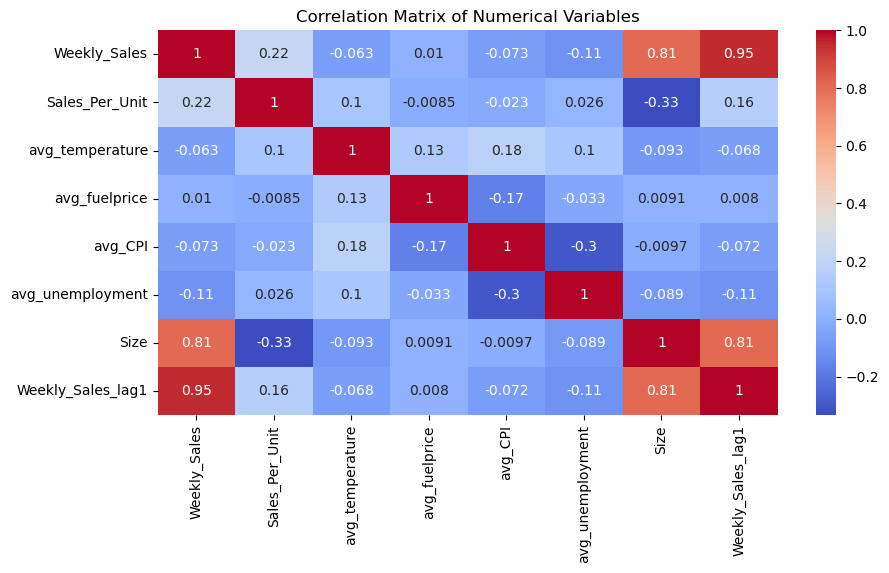

In [73]:
# The first one would likely by a correlation plot
# select numeric columns
numeric_columns = ['Weekly_Sales',
                   'Sales_Per_Unit',
                   'avg_temperature',
                   'avg_fuelprice', 'avg_CPI', 'avg_unemployment', 'Size',
                   'Weekly_Sales_lag1']

corr_df = df_features_store.select(numeric_columns)

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
vector_df = assembler.transform(corr_df).select(vector_col)

matrix = Correlation.corr(vector_df, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

plt.figure(figsize=(10, 5))
sns.heatmap(cor_np,  cmap="coolwarm", annot=True,
            xticklabels=corr_df.columns,
            yticklabels=corr_df.columns)

plt.title("Correlation Matrix of Numerical Variables");

### 2.2.1 Preparing Spark ML Transformers/Estimators for features, labels and models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Decision Tree and Gradient Boosted Tree model for each use case

#### Case 1: Create Transformers and Estimators

In [74]:
# Step 0:
# models
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.regression import DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# transformers
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, Normalizer, StandardScaler

In [75]:
# cast IsHoliday to integer
df_features_store = df_features_store.withColumn(
    "IsHoliday", col("IsHoliday").cast(IntegerType()))

In [148]:
# Step 0: Rename variable
# use dataframe model
df_model = (df_features_store
            .select('Store', 'IsHoliday', 'Type', 'Weekly_Sales_lag1',
                    'Size', 'achieve_goal', 'Weekly_Sales')
            )

# Step 1: String Indexing
# Defining the columns used in the model
inputCols = ['Store', 'IsHoliday', 'Type']

numericCols = ['Weekly_Sales_lag1', 'Size']
outputCols = [f'{x}_index' for x in inputCols]

indexer = StringIndexer(inputCols=inputCols, outputCols=outputCols)

# Step 2:OHE
inputCols_OHE = [x for x in outputCols]
outputCols_OHE = [f'{x}_vec' for x in outputCols]
# append numeric columns

encoder = OneHotEncoder(inputCols=inputCols_OHE,
                        outputCols=outputCols_OHE)

outputCols_OHE += numericCols

# Step 3: Vector Assembler
assembler = VectorAssembler(inputCols=outputCols_OHE,
                            outputCol="features")

# Step 4: Standard Scaling
ss = StandardScaler(
    inputCol="features", outputCol="features_scaled")

# # Step 5: Estimator5
dt_c1 = DecisionTreeClassifier(
    labelCol='achieve_goal', featuresCol='features_scaled',maxDepth=10)
gbt_c1 = GBTClassifier(
    labelCol="achieve_goal", featuresCol="features_scaled", maxIter=48)

#### Case 2: Create Transformers and Estimators

In [149]:
dt_c2 = DecisionTreeRegressor(
    labelCol='Weekly_Sales', featuresCol='features_scaled',maxDepth=10)
gbt_c2 = GBTRegressor(
    labelCol="Weekly_Sales", featuresCol="features_scaled", maxIter=48)

### 2.2.2 Preparing Spark ML Transformers/Estimators for features, labels and models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to include the above Transformers/Estimators into pipelines

#### Case 1: Classification

In [150]:
# pipeline with Decision Tree
pipeline_c1_dt = Pipeline(stages=[indexer, encoder, assembler, ss, dt_c1])
# pipeline with Gradient Boosted DT
pipeline_c1_gbt = Pipeline(
    stages=[indexer, encoder, assembler, ss, gbt_c1])

#### Case 2: Regression

In [151]:
# pipeline with Decision Tree
pipeline_c2_dt = Pipeline(
    stages=[indexer, encoder, assembler, ss, dt_c2])
# pipeline with Gradient Boosted DT
pipeline_c2_gbt = Pipeline(
    stages=[indexer, encoder, assembler, ss, gbt_c2])

### 2.3.1 Preparing the training data and testing data<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to split the data for training and testing purpose - use the data in 2010 and 2012 for training purpose and the half data in 2011 year for training and others as testing purpose; then cache the training and testing data

#### Case 1: Classification

In [152]:
# Split the data by year
train = df_model.filter(
    F.year(col('Date')).isin([2010, 2012])).cache()
test = df_model.filter(F.year(col('Date')).isin([2011])).cache()
# cache training and testng

### 2.4.1 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
For use case 1, write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to perform predictions on the testing data from 2.3

In [153]:
%%time
# Fit on train
# Train model.  This also runs the indexers.
model_c1_dt = pipeline_c1_dt.fit(train)
prediction_c1_dt = model_c1_dt.transform(test)
model_c1_gbt = pipeline_c1_gbt.fit(train)
prediction_c1_gbt = model_c1_gbt.transform(test)
# Transform on Test

CPU times: user 91.5 ms, sys: 25.5 ms, total: 117 ms
Wall time: 1min 14s


### 2.4.2 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
For both models’ results in use case 1, write code to display the count of each combination of above-threshold/below-threshold label and prediction label in formats like the screenshot below. Compute the AUC, accuracy, recall and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs

In [154]:
# table
c1_dt_results = (prediction_c1_dt
                 .select('achieve_goal', 'prediction')
                 .groupBy('achieve_goal', 'prediction')
                 .count()
                 )

c1_gbt_results = (prediction_c1_gbt
                  .select('achieve_goal', 'prediction')
                  .groupBy('achieve_goal', 'prediction')
                  .count()
                  )

print("---- Case 1: Decision Tree Model Results ----\n")
c1_dt_results.show()
print("---- Case 1: Gradient Boosted Tree Model Results ----\n")
c1_gbt_results.show()

---- Case 1: Decision Tree Model Results ----

+------------+----------+-----+
|achieve_goal|prediction|count|
+------------+----------+-----+
|           1|       0.0|  100|
|           0|       0.0| 1223|
|           1|       1.0|  932|
|           0|       1.0|   85|
+------------+----------+-----+

---- Case 1: Gradient Boosted Tree Model Results ----

+------------+----------+-----+
|achieve_goal|prediction|count|
+------------+----------+-----+
|           1|       0.0|   92|
|           0|       0.0| 1224|
|           1|       1.0|  940|
|           0|       1.0|   84|
+------------+----------+-----+



In [155]:
# get AUC, accuracy, recall and precision from Spark API
eval_acc = MulticlassClassificationEvaluator(
    labelCol="achieve_goal", predictionCol="prediction", metricName="accuracy")

eval_rec = MulticlassClassificationEvaluator(
    labelCol="achieve_goal", predictionCol="prediction", metricName="recallByLabel")

eval_prec = MulticlassClassificationEvaluator(
    labelCol="achieve_goal", predictionCol="prediction", metricName="precisionByLabel")

eval_roc = BinaryClassificationEvaluator(
    labelCol="achieve_goal", rawPredictionCol="rawPrediction")


# metrics c1 dt
accuracy_c1_dt = eval_acc.evaluate(prediction_c1_dt)
rec_c1_dt = eval_rec.evaluate(prediction_c1_dt)
prec_c1_dt = eval_prec.evaluate(prediction_c1_dt)
auc_c1_dt = eval_roc.evaluate(prediction_c1_dt)

# metrics c1 gbt
accuracy_c1_gbt = eval_acc.evaluate(prediction_c1_gbt)
rec_c1_gbt = eval_rec.evaluate(prediction_c1_gbt)
prec_c1_gbt = eval_prec.evaluate(prediction_c1_gbt)
auc_c1_gbt = eval_roc.evaluate(prediction_c1_gbt)

print("---- Case 1: Decision Tree Metrics ----")
print("Accuracy = %g " % accuracy_c1_dt)
print("Recall = %g " % rec_c1_dt)
print("Precision = %g " % prec_c1_dt)
print("Area under ROC = %g " % auc_c1_dt)
print("\n")
print("---- Case 1: Gradient Boosted Tree Metrics ----")
print("Accuracy = %g " % accuracy_c1_gbt)
print("Recall = %g " % rec_c1_gbt)
print("Precision = %g " % prec_c1_gbt)
print("Area under ROC = %g " % auc_c1_gbt)

---- Case 1: Decision Tree Metrics ----
Accuracy = 0.92094 
Recall = 0.935015 
Precision = 0.924414 
Area under ROC = 0.899502 


---- Case 1: Gradient Boosted Tree Metrics ----
Accuracy = 0.924786 
Recall = 0.93578 
Precision = 0.930091 
Area under ROC = 0.9773 


### 2.4.2 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Draw a ROC plot for any model you want

In [156]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html


class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter,
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2,
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [157]:
import matplotlib.pyplot as plt
from matplotlib import style


def roc_plot(predictions, labelcol, title):

    # Returns as a list (false positive rate, true positive rate)
    preds = (predictions
             .select(labelcol,'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row[labelcol]))))
    roc=CurveMetrics(preds).get_curve('roc')
    plt.figure()
    x_val=[x[0] for x in roc]
    y_val=[x[1] for x in roc]
    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.style.use('ggplot')
    plt.plot(x_val, y_val);

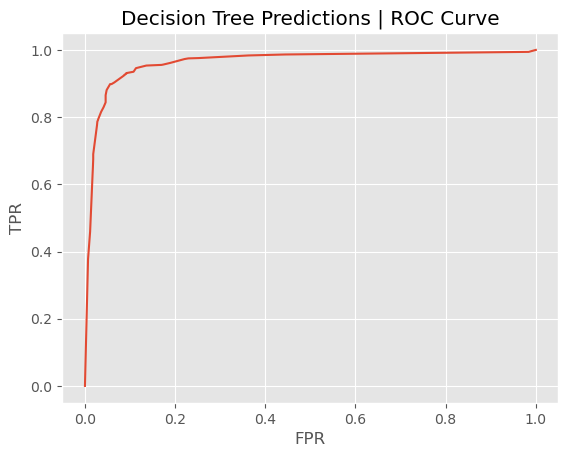

In [158]:
roc_plot(prediction_c1_dt,'achieve_goal','Decision Tree Predictions | ROC Curve')

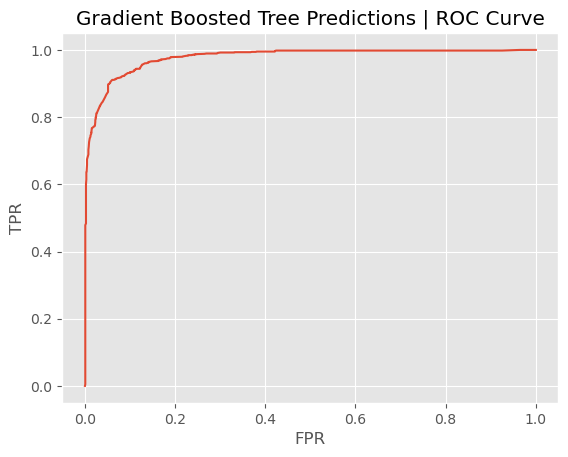

In [159]:
roc_plot(prediction_c1_gbt,'achieve_goal','Gradient Boosted Tree Predictions | ROC Curve')

### 2.4.2 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Discuss which is the better model

Discussion In the Document Part 

### 2.4.3 Training and evaluating models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
For use case 2, write code to use the corresponding ML Pipelines to train the models on the cache training data from 2.3. And then use the trained models to perform predictions on the testing data from 2.3

In [160]:
%%time
# Fit on train
# Train model.  This also runs the indexers.
model_c2_dt = pipeline_c2_dt.fit(train)
prediction_c2_dt = model_c2_dt.transform(test)
model_c2_gbt = pipeline_c2_gbt.fit(train)
prediction_c2_gbt = model_c2_gbt.transform(test)
# Transform on Test

CPU times: user 113 ms, sys: 31.3 ms, total: 144 ms
Wall time: 1min 13s


### 2.4.4 Evaluate regression models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Persist the better model you selected

In [161]:
# Select (prediction, true label) and compute test error
eval_r2 = RegressionEvaluator(labelCol="Weekly_Sales",
                                predictionCol="prediction",
                                metricName="r2")

eval_rmse = RegressionEvaluator(labelCol="Weekly_Sales",
                                 predictionCol="prediction",
                                 metricName="rmse")
# obtain R2 for both models
r2_c2_dt, r2_c2_gbt = (eval_r2.evaluate(prediction_c2_dt), evaluator.evaluate(prediction_c2_gbt)
                       )
# obtain rmse for both models
rmse_c2_dt, rmse_c2_gbt = (eval_rmse.evaluate(prediction_c2_dt), evaluator2.evaluate(prediction_c2_gbt)
                           )
print("---- Case 2: Decision Tree Regression Model Results ----\n")
print("Decision Tree model R2 = %g " % r2_c2_dt)
print("Decision Tree model rmse = %g " % rmse_c2_dt)
print("\n")
print("---- Case 2: Gradient Boosted Tree Regression Model Results ----\n")
print("GBT model R2 = %g " % r2_c2_gbt)
print("GBT model rmse = %g " % rmse_c2_gbt)

---- Case 2: Decision Tree Regression Model Results ----

Decision Tree model R2 = 0.930036 
Decision Tree model rmse = 150677 


---- Case 2: Gradient Boosted Tree Regression Model Results ----

GBT model R2 = 0.935557 
GBT model rmse = 144610 


In [162]:
# Research Persistence

### 2.4.5 Evaluate regression models<a class="anchor" id="1.1.1"></a>
[Back to top](#table)
Write code to print out the features with each corresponding feature importance for the GBT model, ranked the result based on feature importance.

### 3.1 Knowledge sharing
How many jobs are observed when training the KMeans clustering model following the code below? Provide a screenshot from Spark UI for running a simple KMeans model training from the provided data

### 3.2 Explaining Kmeans
Combining the parallelism theory from lecture, Spark source code, and the Spark UI, discuss which parallelism of the kmeans algorithm in spark is more likely to belong to, data parallelism or result parallelism?
- 300 words max for the discussion
- Hint - you can also refer to the Spark source code on github https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/mllib/clustering/KMeans.scala


Answer: In the documentation

# Resources

https://12ft.io/proxy?&q=https%3A%2F%2Ftowardsdatascience.com%2Fapache-spark-caching-603154173c48

https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame

https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve